# MCTS 알고리즘을 사용한 체스 플레이 딥러닝 모델 구현하기

## 구현 단계

1. 환경 설정   

    `python-chess` 환경을 사용하여 게임 진행 상황을 추적하고, 가능한 모든 수를 관리

2. 상태 ( State ) 와 행동 ( Action )
    - 상태 : 체스판의 현재 상태르 나타내며, 체스말의 위치나 게임의 진행 상황을 포함한다.
    - 행동 : 각 상태에서 할 수 있는 체스의 가능한 수를 정의한다.

3. 보상 ( Reward )
    - 승리 : 게임에서 승리하면 큰 보상을 주소, 패배하면 큰 벌점을 주는 방식으로 보상을 설정할 수 있다.
    - 중간 보상 : 특정 목표를 달성했을 때 보상을 주는 방식으로도 설정할 수 있다.

4. 강화학습 알고리즘 선택
    - Q-learning
    - DQL
    - MCTS : MCTS + 신경망 채택

5. 신경망 모델 설계

6. 훈련

In [ ]:
# python-chess 모듈 사용
! pip install python-chess cairosvg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 47.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=07da6a1719980967116443996db2099cd1531ae0a8f30f6b48d1ed38b0a68e32
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


## MCTS 체스 플레이 모델 구현을 위한 단계

1. 게임 환경 설정:

    python-chess를 사용하여 체스 게임 환경을 설정합니다.

2. MCTS 트리 구조:

    각 상태와 행동을 트리의 노드로 나타냅니다.

    상태별로 트리의 노드를 확장하고 시뮬레이션을 진행하여 백업을 수행합니다.

3. 보상과 평가:

    승리 시 보상은 +1, 패배 시 -1로 설정하고, 무승부는 0으로 설정할 수 있습니다.

    각 시뮬레이션에서 얻은 결과를 기반으로 노드의 값을 업데이트합니다.

4. 게임 진행 및 학습:

    여러 번의 게임을 통해 모델이 최적의 전략을 찾아가도록 훈련합니다.


### MCTS 의 과정

1. 선택 ( Selection )
    현재 상태에서 가장 유망한 노드를 선택

2. 확장 ( Expansion )
    선택된 노드에 자식 노드를 추가

3. 시뮬레이션 ( Simulation )
    확장된 노드에서 게임을 랜덤 또는 정책적으로 진행

4. 백업 ( Backpropagation )
  시뮬레이션의 결과를  트리로 되돌려보냄

In [ ]:
import math

class Node:
    def __init__(self, board, parent=None, action=None):
        self.board = board  # 체스 보드 상태
        self.parent = parent  # 부모 노드
        self.children = []  # 자식 노드들
        self.visit = 0  # 방문 횟수
        self.wins = 0  # 승리 횟수
        self.untried_moves = list(board.legal_moves)  # 아직 시도하지 않은 수들
        self.game_over = board.is_game_over()
        if self.game_over:
            self.untried_moves = []
        # action: 부모 노드에서 선택한 이동; 루트는 None
        self.action = action  # action은 UCI 문자열 (예: "e2e4")

    def uct_value(self):
        if self.visit == 0:
            return float('inf')
        return self.wins / self.visit + math.sqrt(2 * math.log(self.parent.visit) / self.visit)

    def best_child(self, policy_probabilities):
        """
        자식 노드들 중에서 UCT 값과 정책 네트워크의 확률을 결합하여 가장 높은 값을 가진 자식을 선택
        policy_probabilities: 현재 노드의 legal_moves에 대응하는 확률 배열 (길이 = len(legal_moves))
        """
        max_value = float('-inf')
        selected_child = None

        legal_moves = list(self.board.legal_moves)
        # 만약 정책 확률의 크기가 legal_moves와 다르면 에러 처리
        if len(policy_probabilities) != len(legal_moves):
            print("Error: Policy probabilities length does not match number of legal moves.")
            return None

        for child in self.children:
            # child.board.peek()는 자식 노드로 도달한 마지막 이동
            move = child.board.peek()
            if move not in legal_moves:
                continue
            move_index = legal_moves.index(move)
            # 결합: UCT + 정책 확률(여기서는 단순 합산; 하이퍼파라미터 조정 가능)
            value = child.uct_value() + policy_probabilities[move_index]
            if value > max_value:
                max_value = value
                selected_child = child
        return selected_child


### UCT란?

UCT는 트리 탐색에서 어떤 노드를 선택할지 결정하는 방식 중 하나이다.
MCTS 알고리즘에서 각 노드 ( 게임 상태 ) 의 가치를 평가하는 데 사용되며 이 값을 기반으로 가장 유망한 경로를 선택하려는 것이다.

### 왜 UCT가 필요한가?

게임  트리나 검색 트리에서 가능한 수들은 많기 때문에 모든 경로를 시도할 수는 없다.
대신, **가장 유망한 경로**를 선택하고, 그 경로를 더 깊게 탐색해야 한다. 그러나 경로를 선택하는 데 있어서 두 가지 중요한 요소가 필요하다

1. 이미 알고 있는 정보 : 그 경로가 얼마나 좋은지

2. 모르는 정보 : 아직 탐색되지 않은 새로운 경로를 탐색할 가능성

### UCT 공식

$ UCT = \frac {W_ {i}}{N_ {i}} $ + C ⋅ $\sqrt \frac {\ln (N_ {p})}{N_ {i}} $

$ {W_ {i}} $ : 노드 i의 승리 횟수. 이 값이 노드에서 시뮬레이션된 게임 결과 중 승리한 비율
$ {N_ {i}} $ : 노드 i의 방문 횟수  
$ {N_ {p}} $ : 부모 노드의 방문 횟수  
$ C $ : 탐색 파라미터, 탐색과 착수 간의 균형을 조절하는 값, 보통 $ C = \sqrt 2 $ 정도로 설정된다.

### UCT의 두 가지 중요 오소

1. 탐사 ( Exploration ) : 새로운 경로를 탐색하는 것
    - UCT 에서  $\sqrt \frac {\ln (N_ {p})}{N_ {i}} $ 는 "탐사" 요소이다. 이 부분은 방문 횟수가 적은 노드를 더 많이 탐색하려는 성향이 있다. 즉, 덜 방문된 노드를 더 자주 선택하게 한다.

2. 착수 ( Exploitation ) : 이미 알고 있는 정보에 기반하여 최적의 경로를 선택하는 것   
    - UCT에서 $\frac {W_ {i}}{N_ {i}} $ 는 "착수" 요소이다. 이는 해당 경로에서 얼마나 승리했는지를 나타내며, 이미 좋은 결과를 낸 경로를 반복적으로 선택하려는 성향을 가지고 있다.

### UCT의 동작 방식
탐사(Exploration): 경로를 탐색할 때, 아직 충분히 탐색되지 않은 경로에 대해 더 많은 시도를 하려는 성향을 갖는다. 이 부분은 트리의 깊이가 부족하거나, 아직 게임이 진행되지 않은 경로에서 중요하다.

착수(Exploitation): 이미 여러 번 방문한 경로가 있을 때, 그 경로의 승리 비율이 높다면, 그 경로를 더 자주 선택하게 된다. 즉, 이미 좋은 결과를 낸 경로를 계속 탐색하는 방식이다.

### UCT의 장점
균형을 잘 맞춘다. 너무 탐사만 하거나, 너무 착수만 하면 안 되기에. UCT는 두 가지를 균형 있게 고려하여 최적의 경로를 선택할 수 있게 해준다.

동적 탐색을 가능하게 한다. 게임 상황이 달라지면 탐색 전략도 달라지므로, 상황에 맞게 탐색을 잘 조절할 수 있다.

In [ ]:
class MCTS:
  def __init__(self, root, max_simulations=1000):
    self.root = root  # 시작 노드 (root 노드). 게임의 초기 상태입니다.
    self.max_simulations = max_simulations  # 시뮬레이션 횟수 (기본값은 1000). MCTS가 반복하여 탐색할 횟수입니다.

  def run(self):
    for _ in range(self.max_simulations):  # 시뮬레이션 횟수만큼 실행
        node = self.select(self.root)  # 시작 노드를 기준으로 트리에서 탐색을 시작합니다.
        if not node.game_over:  # 게임이 아직 끝나지 않았다면
            self.expand(node)  # 아직 시도하지 않은 수가 있으면 새로운 노드를 추가
        simulation_result = self.simulate(node)  # 현재 상태에서 랜덤으로 게임을 진행하여 결과를 예측
        self.backpropagate(node, simulation_result)  # 시뮬레이션 결과를 부모 노드로 전달

  def select(self, node):
    # 선택: UCT 값을 이용하여 자식 노드 중 하나를 선택
    while node.untried_moves == [] and node.children:  # 시도하지 않은 수가 없고, 자식 노드를 가지고 있다면
        node = node.best_child()  # UCT 값이 가장 높은 자식 노드를 선택
    return node  # 선택한 노드를 반환

  def expand(self, node):
    # 확장: 아직 시도하지 않은 수가 있다면, 새로운 자식 노드를 추가
    move = node.untried_moves.pop()  # 아직 시도하지 않은 수들에서 하나를 꺼냄
    new_board = node.board.copy()  # 현재 보드 상태를 복사하여 새로운 보드 상태 생성
    new_board.push(move)  # 시도하지 않은 수를 보드에 적용
    child_node = Node(new_board, parent=node)  # 새 보드 상태로 자식 노드 생성
    node.children.append(child_node)  # 부모 노드에 자식 노드를 추가

  def simulate(self, node):
    # 시뮬레이션: 게임을 랜덤으로 진행하여 결과를 예측
    board_copy = node.board.copy()  # 현재 보드 상태를 복사하여 진행
    while not board_copy.is_game_over():  # 게임이 끝날 때까지
        legal_moves = list(board_copy.legal_moves)  # 현재 가능한 모든 수를 가져옴
        move = random.choice(legal_moves)  # 그 중에서 하나를 무작위로 선택
        board_copy.push(move)  # 선택한 수를 보드에 적용
    if board_copy.is_checkmate():
        return 1  # 상대방을 체크메이트 시켰으므로 승리
    elif board_copy.is_stalemate() or board_copy.is_insufficient_material():
        return 0.5  # 무승부 또는 재료 부족으로 게임 종료
    else:
        return 0  # 패배

  def backpropagate(self, node, result):
    # 백업: 시뮬레이션 결과를 트리 위로 되돌려 보냄
    while node:
        node.visits += 1  # 이 노드를 방문했음을 표시
        node.wins += result  # 시뮬레이션 결과에 따라 승리 횟수 업데이트
        node = node.parent  # 부모 노드로 이동

MCTS 코드를 사용해 딥러닝 모델을 훈련시키기

## 딥러닝 모델을 훈련시키기 위한 주요 단계
1. 딥러닝 모델 설계

체스에서 사용할 정책 네트워크 ( Policy Network ) 와 가치 네트워크 ( Value Network ) 를 설계한다. 이 모델들은 체스 보드 상태를 입력으로 받아, 각각의 수에 대한 확률 분포 ( 정책 네트워크 ) 와 게임의 승리 확률 ( 가치 네트워크 ) 를 출력한다.

2. 데이터 수집

모델을 훈련시키기 위해 많은 게임 데이터를 수집한다.

3. 훈련 루프

4. 훈련을 위한 손실 함수 설계
- 정책 네트워크의 경우, 실제 선택된 수와 네트워크가 예측한 확률 분포 간의 차이를 최소화하는 교차 엔트로피 손실 ( cross entropy loss )를 사용

- 가치 네트워크의 경우, 실제 게임의 결과와 모델이 예측한 가치 간의 차이를최소화하는 평균 제곱  오차 ( MSE )를 사용

### 정책 네트워크 ( Policy Network )
정책 네트워크는 주어진 체스 보드 상태에서 어떤 수를 두는 것이 좋을지 예측하는 모델
이 모델을 체스 보드 상태를 입력받아 각 가능한 수의 확률을 출력한다. 예를 들어, 체스에서 각 플레이는 약 4672개의 가능한 수 중 하나일 수 있기엥, 정책 네트워크는 이 4672개의 수에 대해 각 수가 선택될 확률을 예측한다.

목표 : 이 네트워크는 체스 보드 상태에 대해 각 수의 확률을 예측하여 MCTS가 가장 유망한 수를 선택하는 데 도움을 준다.

### 가치 네트워크 ( Value Network )
가치 네트워크는 주어진 체스 보드 상태에 대해 게임 결과의 승리 확률을 예측하는 모델
이 모델을 체스 보드 상태를 입력받아 그 상태에서 승리할 확률을 출력한다.

목표 : MCTS가 각 노드에서 게임 종료 후 승리 확률을 예측하여, 더 나은 수를 선택할 수 있도록 돕는다.

In [ ]:
import random
import torch
import torch.nn as nn #  PyTorch의 Neural Network 모듈을 포함하는 모듈
import torch.optim as optim #  PyTorch에서 제공하는 최적화(optimizer) 알고리즘을 포함하는 모듈
import chess

# 정책 네트워크 ( Policy Network )
class PolicyNetwork(nn.Module):
    def __init__(self):
      super(PolicyNetwork, self).__init__()
      self.conv1 = nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)  # Conv2D: 보드 상태를 특징 맵으로 변환
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
      self.fc1 = nn.Linear(64 * 8 * 8, 256) # Fully Connected Layer ( 1차원 벡터로 변환 )
      self.fc2 = nn.Linear(256, 4672) # 체스에서 가능한 수의 개수 ( 4672 개의 수 예측 )

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # 확률 값 출력
        return x

# 가치 네트워크 (Value Network)
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)  # Conv2D: 보드 상태를 특징 맵으로 변환
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Fully connected layer (1차원 벡터로 변환)
        self.fc2 = nn.Linear(256, 1)  # 승리 확률 예측

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # ReLU 활성화 함수
        x = torch.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = torch.relu(self.fc1(x))  # ReLU 활성화 함수
        x = torch.sigmoid(self.fc2(x))  # 승리 확률 출력 (0~1 사이 값)
        return x

#  Conv2D ( 2D 합성곱 레이어 )

Conv2D는 이미지나 2D 데이터를 처리하는 데 주로 사용되는 신경망의 한 종류로, 주어진 데이터를 작은 부분들로 나누어 각 부분에 대해 연산을 수행합니다. **합성곱(Convolution)**은 입력 데이터와 커널(Kernel) 또는 **필터(Filter)**라는 작은 행렬을 이용해 **특징 맵(Feature Map)**을 생성하는 연산입니다.

# 활성화 함수
활성화 함수는 신경망의 각 노드에서 출력값을 결정하는 역할을 합니다. 신경망은 입력 데이터를 처리하여 결과를 생성하는데, 이 과정에서 각 층에서의 출력을 비선형적으로 변형하기 위해 활성화 함수가 사용됩니다.

In [ ]:
import numpy as np

class MCTSWithNN:
    def __init__(self, root, policy_net, value_net, max_simulations=1000, learning_rate=1e-4):
        """
        root : MCTS의 시작 노드를 지정 ( 초기 보드 상태 )
        policy_net : 정책 네트워크
        value_net : 가치 네트워크
        max_simulations : MCTS가 시뮬레이션을 실행할 횟수
        learning_rate :  네트워크 훈련에 사용할 학습률, 보통 작은 값을 사용하여 안정적인 학습을 진행

        optimizer_policy 와 optimizer_value : 각각 정책 네트워크와 가치 네트워크를 학습하는 데 사용되는 옵티마이저 ( 최소값을 찾아가는 최적화 알고리즘 )
        """
        # MCTS 알고리즘과 정책 네트워크, 가치 네트워크를 초기화
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 사용 여부 확인

        self.root = root  # 시작 노드 (체스 보드 상태)
        self.max_simulations = max_simulations  # MCTS 시뮬레이션 횟수 (보통 많을수록 정확도 상승)
        self.policy_net = policy_net.to(self.device)  # 정책 네트워크 (수 선택 확률을 예측)
        self.value_net = value_net.to(self.device)  # 가치 네트워크 (현재 보드의 승리 확률을 예측)

        # 정책 네트워크와 가치 네트워크에 대한 Adam 옵티마이저 설정
        self.optimizer_policy = optim.Adam(policy_net.parameters(), lr=learning_rate)
        self.optimizer_value = optim.Adam(value_net.parameters(), lr=learning_rate)

    def board_to_tensor(self, board):
        """
        체스 보드 상태를 8x8x12 PyTorch 텐서로 변환
        """
        piece_map = {
            'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,  # 백 기물
            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11  # 흑 기물
        }
        board_matrix = np.zeros((12, 8, 8), dtype=np.float32)  # 12채널 (각 기물마다 한 개 채널)

        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                row, col = divmod(square, 8)
                board_matrix[piece_map[piece.symbol()], row, col] = 1

        return torch.tensor(board_matrix, dtype=torch.float32).to(self.device)

    def run(self):
        for _ in range(self.max_simulations):
            node = self.select(self.root)  # 노드 선택 (UCT + 정책 네트워크 활용), 최적의 자식 노드를 선택하는 과정
            if not node.game_over:
                self.expand(node)  # 노드 확장 (자식 노드 추가)
            simulation_result = self.simulate(node)  # 시뮬레이션 (가치 네트워크 사용)
            self.backpropagate(node, simulation_result)  # 모든 노드에 백프로파게이션 수행

    def select(self, node):
        while node.untried_moves == [] and node.children:
            board_tensor = self.board_to_tensor(node.board).unsqueeze(0).to(self.device)
            policy_probabilities = self.policy_net(board_tensor).cpu().detach().numpy().flatten()

            legal_moves = list(node.board.legal_moves)
            legal_move_indices = [legal_moves.index(move) for move in node.untried_moves]

            masked_policy_probabilities = np.zeros(len(legal_moves))
            masked_policy_probabilities[legal_move_indices] = policy_probabilities[legal_move_indices]

            node = node.best_child(masked_policy_probabilities)
        return node

    def expand(self, node):
        move = node.untried_moves.pop()  # 아직 시도되지 않은 수 선택
        new_board = node.board.copy()  # 현재 보드 상태 복사
        new_board.push(move)  # 선택된 수를 적용하여 보드 상태 갱신
        child_node = Node(new_board, parent=node, action=move.uci())  # 새로운 자식 노드 생성, move.uci()를 문자열로 저장
        node.children.append(child_node)  # 부모 노드에 자식 노드 추가

    def simulate(self, node):
        # 시뮬레이션: 가치 네트워크로 결과 예측
        board_tensor = self.board_to_tensor(node.board)
        value = self.value_net(board_tensor.unsqueeze(0)).item()  # 배치 차원 추가
        return value

    def backpropagate(self, node, result):
        # 백프로파게이션
        while node:
            node.visit += 1  # 방문 횟수 증가
            node.wins += result  # 승리 결과 반영
            node = node.parent  # 부모 노드로 이동

    def train(self, episodes=1000):
        # 훈련 루프: MCTS를 통해 수집한 데이터를 사용하여 딥러닝 모델 훈련
        for _ in range(episodes):
            self.run()  # MCTS 시뮬레이션 실행
            states, actions, results = self.collect_training_data()  # 훈련 데이터 수집
            self.train_policy_network(states, actions)  # 정책 네트워크 훈련
            self.train_value_network(states, results)  # 가치 네트워크 훈련

    def collect_training_data(self):
        # MCTS가 수집한 데이터를 반환하는 메소드
        states, actions, results = [], [], [] # states : MCTS 시뮬레이션 중에 만난 모든 상태를 수집, actions : 각 상태에서 선택된 수를 기록, results : 해당 상태에서 게임의 결과
        for node in self.root.children:
            board_tensor = self.board_to_tensor(node.board)
            states.append(board_tensor.to(self.device))  # 상태 (텐서 형태)
            actions.append(torch.tensor(move_to_index(node.action), device=self.device))  # 선택된 행동
            result = node.wins / node.visit if node.visit > 0 else 0.0
            results.append(result)
        return states, actions, results

    def train_policy_network(self, states, actions):
        # 정책 네트워크 훈련
        self.policy_net.train()  # 훈련 모드로 설정
        self.optimizer_policy.zero_grad()  # 기울기 초기화
        states = torch.stack(states).to(self.device)
        # actions는 move를 문자열로 저장하므로, 이를 인덱스로 변환해야 함
        actions = [move_to_index(action) for action in actions]
        actions = torch.tensor(actions, device=self.device)
        outputs = self.policy_net(states)  # 정책 네트워크 출력
        loss = nn.CrossEntropyLoss()(outputs, actions)  # 교차 엔트로피 손실 계산
        loss.backward()  # 기울기 계산
        self.optimizer_policy.step()  # 파라미터 업데이트

    def train_value_network(self, states, results):
        # 가치 네트워크 훈련
        self.value_net.train() # 훈련 모드로 설정
        self.optimizer_value.zero_grad() # 기울기 초기화
        states = torch.stack(states).to(self.device)
        results = torch.tensor(results, device=self.device, dtype=torch.float32).unsqueeze(1)
        predictions = self.value_net(states) # 가치 네트워크 출력
        loss = nn.MSELoss()(predictions, results)  # 평균 제곱 오차 손실
        loss.backward() # 기울기 계산
        self.optimizer_value.step() # 파라미터 업데이트

In [ ]:
def move_to_index(move_uci):
    """
    주어진 UCI 문자열(move_uci)을 고정된 액션 공간(4672)의 인덱스로 변환합니다.
    실제 환경에서는 모든 가능한 이동에 대한 사전(mapping)을 미리 구축해야 합니다.
    여기서는 예시로 단순히 해시를 이용해 범위 내의 인덱스로 매핑합니다.
    """
    # 예시: 해시 값을 4672로 모듈로 연산
    return abs(hash(move_uci)) % 4672

# 정책 네트워크와 가치 네트워크 초기화
policy_net = PolicyNetwork()
value_net = ValueNetwork()

# 초기 체스 보드 상태 생성 (체스판 초기화)
initial_board = chess.Board()

# 루트 노드 생성 (루트 노드에서는 action은 None)
root_node = Node(initial_board)

# MCTSWithNN 객체 생성
mcts_nn = MCTSWithNN(root=root_node, policy_net=policy_net, value_net=value_net,
                     max_simulations=3000, learning_rate=1e-4)

# 학습 시작
print("🔄 모델 학습 시작...")
mcts_nn.train(episodes=3000)  # 3 000 에피소드 학습 진행
print("✅ 모델 학습 완료!")

# 학습된 모델 저장
torch.save(policy_net.state_dict(), "./policy_net.pth")
torch.save(value_net.state_dict(), "./value_net.pth")
print("💾 학습된 모델이 저장되었습니다!")

🔄 모델 학습 시작...


In [ ]:
import chess
import torch
import numpy as np

# 정책 네트워크와 가치 네트워크 클래스가 이미 정의되어 있다고 가정합니다.
# 예시: PolicyNetwork, ValueNetwork

# 저장된 모델 불러오기
policy_net = PolicyNetwork()
value_net = ValueNetwork()

# 저장된 state_dict 로드 (경로는 필요에 맞게 조정)
policy_net.load_state_dict(torch.load("./policy_net.pth", map_location="cpu"))
value_net.load_state_dict(torch.load("./value_net.pth", map_location="cpu"))

# 평가 모드로 전환
policy_net.eval()
value_net.eval()

# GPU 사용 여부 결정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device)
value_net.to(device)

def board_to_tensor(board):
    """
    체스 보드를 12x8x8 텐서로 변환하고 배치 차원을 추가 (1, 12, 8, 8)
    """
    piece_map = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    board_matrix = np.zeros((12, 8, 8), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)
            board_matrix[piece_map[piece.symbol()], row, col] = 1
    # 배치 차원 추가 및 디바이스 이동
    return torch.tensor(board_matrix, dtype=torch.float32).unsqueeze(0).to(device)

# 테스트할 체스 보드 (초기 보드 상태)
test_board = chess.Board()
test_board_tensor = board_to_tensor(test_board)

with torch.no_grad():
    # 정책 네트워크 출력 (로짓) -> softmax를 적용하여 확률 분포 생성
    policy_logits = policy_net(test_board_tensor)
    policy_probs = torch.softmax(policy_logits, dim=1)
    # 가치 네트워크 출력 (0~1 사이의 값)
    board_value = value_net(test_board_tensor)

print("Test Board:")
print(test_board)
print("Policy probabilities shape:", policy_probs.shape)  # 예상: (1, 4672)
print("Value prediction:", board_value.item())


Test Board:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Policy probabilities shape: torch.Size([1, 4672])
Value prediction: 0.5143652558326721


초기 체스판:


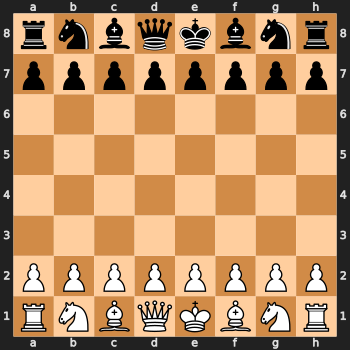

AI의 턴:
AI가 둔 수: e2e4


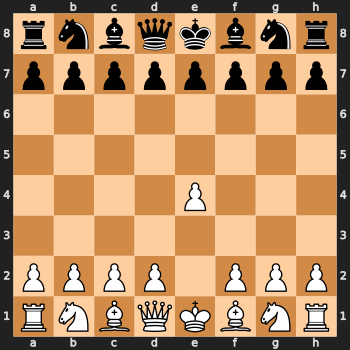

사용자의 턴:


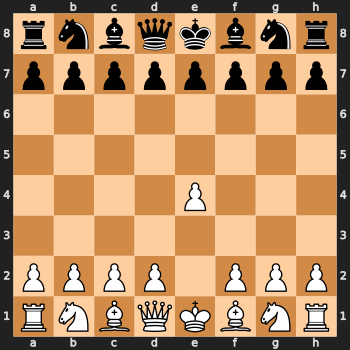

UCI 형식으로 수를 입력하세요 (예: e2e4): c8d7
잘못된 수입니다. 합법적인 수를 입력하세요.
UCI 형식으로 수를 입력하세요 (예: e2e4): b8b6
잘못된 수입니다. 합법적인 수를 입력하세요.
UCI 형식으로 수를 입력하세요 (예: e2e4): b8a6


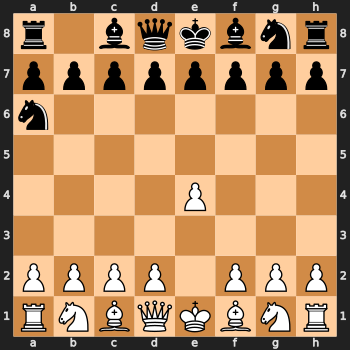

AI의 턴:
AI가 둔 수: a2a3


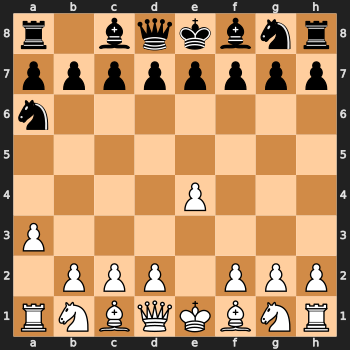

사용자의 턴:


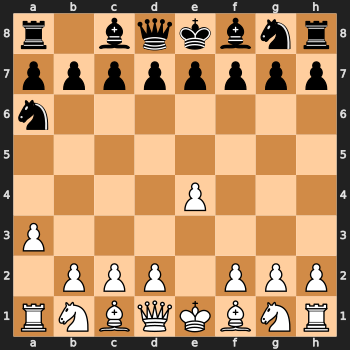

KeyboardInterrupt: Interrupted by user

In [ ]:
import chess
import chess.svg
from IPython.display import SVG, display
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random

# 정책 네트워크 (Policy Network)
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 4672)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 가치 네트워크 (Value Network)
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# 헬퍼 함수: 체스 보드를 텐서로 변환
def board_to_tensor(board, device):
    piece_map = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    board_matrix = np.zeros((12, 8, 8), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)
            board_matrix[piece_map[piece.symbol()], row, col] = 1
    tensor = torch.tensor(board_matrix, dtype=torch.float32).unsqueeze(0).to(device)
    return tensor

# 헬퍼 함수: UCI 문자열을 인덱스로 변환
def move_to_index(move_uci):
    return abs(hash(move_uci)) % 4672

# 모델 불러오기 및 평가모드 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = PolicyNetwork().to(device)
value_net = ValueNetwork().to(device)
policy_net.load_state_dict(torch.load("./policy_net.pth", map_location=device))
value_net.load_state_dict(torch.load("./value_net.pth", map_location=device))
policy_net.eval()
value_net.eval()

# AI가 가장 좋은 수를 선택하는 함수 (간단한 예시)
def get_best_move(board):
    tensor = board_to_tensor(board, device)
    with torch.no_grad():
        logits = policy_net(tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
    legal_moves = list(board.legal_moves)
    if not legal_moves:
        return None
    move_probs = []
    for move in legal_moves:
        idx = move_to_index(move.uci())
        move_probs.append(probs[idx])
    best_move = legal_moves[np.argmax(move_probs)]
    return best_move

# 체스판을 SVG로 표시하는 함수
def display_board(board):
    svg_board = chess.svg.board(board=board, size=350)
    display(SVG(svg_board))

# 게임 플레이 함수 (AI와 사용자가 번갈아 수를 둡니다)
def play_game():
    board = chess.Board()
    print("초기 체스판:")
    display_board(board)

    while not board.is_game_over():
        # AI의 턴
        print("AI의 턴:")
        ai_move = get_best_move(board)
        if ai_move is None:
            break
        print("AI가 둔 수:", ai_move.uci())
        board.push(ai_move)
        display_board(board)

        if board.is_game_over():
            break

        # 사용자 턴
        print("사용자의 턴:")
        display_board(board)

        while True:
            user_input = input("UCI 형식으로 수를 입력하세요 (예: e2e4): ").strip()
            try:
                user_move = chess.Move.from_uci(user_input)
                if user_move in board.legal_moves:
                    board.push(user_move)
                    display_board(board)
                    break  # 유효한 수가 입력되면 루프를 탈출
                else:
                    print("잘못된 수입니다. 합법적인 수를 입력하세요.")
            except Exception as e:
                print("입력 형식이 올바르지 않습니다. (예: e2e4)")

    print("게임 종료!")
    print("결과:", board.result())

# 게임 실행
play_game()


In [ ]:
b